In [1]:
from google.colab import files
uploaded = files.upload()

Saving cervical_data.csv to cervical_data.csv


In [2]:
# Cell 1 — imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier


In [3]:
# Cell 2 — load data and basic info

DATA_PATH = "cervical_data.csv"  # adjust path if needed

df = pd.read_csv(DATA_PATH)

STAGE_COL = "Derived EOD 2018 Stage Group Recode (2018+)"  # we will use this variable

print("Initial shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nStage value counts (raw):")
print(df[STAGE_COL].value_counts(dropna=False))


Initial shape: (16820, 14)

Columns:
['Derived EOD 2018 Stage Group Recode (2018+)', 'Age recode with <1 year olds and 90+', 'Year of diagnosis', 'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Regional nodes positive (1988+)', 'SEER Combined Mets at DX-bone (2010+)', 'SEER Combined Mets at DX-brain (2010+)', 'SEER Combined Mets at DX-liver (2010+)', 'SEER Combined Mets at DX-lung (2010+)', 'Tumor Size Over Time Recode (1988+)', 'EOD Regional Nodes Recode (2018+)', 'Sex', 'Race recode (W, B, AI, API)']

Stage value counts (raw):
Derived EOD 2018 Stage Group Recode (2018+)
4B         2165
1B1        2034
1A1        2025
2B         1764
99         1182
3C1        1101
1B2        1021
3B          946
1B          759
1A2         620
4A          457
2A2         455
3A          368
2A1         283
1B3         269
3C2         268
1           223
88          221
2           192
1A          177
3           136
2A          111
1E           27
2E            6
4             5
3C           

In [4]:
# Cell 3 (OPTIONAL) — rename stage column to a shorter name

df = df.rename(columns={
    "Derived EOD 2018 Stage Group Recode (2018+)": "Stage_raw"
})
STAGE_COL = "Stage_raw"  # update our variable

print("Renamed stage column to:", STAGE_COL)
print(df[STAGE_COL].value_counts(dropna=False))


Renamed stage column to: Stage_raw
Stage_raw
4B         2165
1B1        2034
1A1        2025
2B         1764
99         1182
3C1        1101
1B2        1021
3B          946
1B          759
1A2         620
4A          457
2A2         455
3A          368
2A1         283
1B3         269
3C2         268
1           223
88          221
2           192
1A          177
3           136
2A          111
1E           27
2E            6
4             5
3C            3
2 bulky       2
Name: count, dtype: int64


In [5]:
# Cell 4 — map detailed SEER stage → 4-category Stage_4cat

stage_map = {}

# Stage 1 family
for s in ["1", "1A", "1A1", "1A2", "1B", "1B1", "1B2", "1B3", "1E"]:
    stage_map[s] = 1

# Stage 2 family
for s in ["2", "2A", "2A1", "2A2", "2B", "2E", "2 bulky"]:
    stage_map[s] = 2

# Stage 3 family
for s in ["3", "3A", "3B", "3C", "3C1", "3C2"]:
    stage_map[s] = 3

# Stage 4 family
for s in ["4", "4A", "4B"]:
    stage_map[s] = 4

# labels to drop (unknown / unstaged)
drop_labels = ["88", "99"]

# drop unknown/unstaged rows
df = df[~df[STAGE_COL].isin(drop_labels)].copy()

# apply mapping
df["Stage_4cat"] = df[STAGE_COL].map(stage_map)

# drop any rows that didn't map (safety)
df = df[~df["Stage_4cat"].isna()].copy()
df["Stage_4cat"] = df["Stage_4cat"].astype(int)

print("After mapping to 1/2/3/4:")
print(df["Stage_4cat"].value_counts().sort_index())
print("Shape after filtering:", df.shape)


After mapping to 1/2/3/4:
Stage_4cat
1    7155
2    2813
3    2822
4    2627
Name: count, dtype: int64
Shape after filtering: (15417, 15)


In [12]:
# NEW CELL (after Cell 4) — encode labels for XGBoost

# Stage_4cat is 1,2,3,4 —> make encoded version 0,1,2,3
df["Stage_4cat_enc"] = df["Stage_4cat"] - 1

print(df[["Stage_4cat", "Stage_4cat_enc"]].head())
print("Encoded class value counts:")
print(df["Stage_4cat_enc"].value_counts().sort_index())


   Stage_4cat  Stage_4cat_enc
0           1               0
1           1               0
2           1               0
3           1               0
4           1               0
Encoded class value counts:
Stage_4cat_enc
0    7155
1    2813
2    2822
3    2627
Name: count, dtype: int64


In [13]:
# Cell 5 — define features (X) and target (y), drop leakage

target_col = "Stage_4cat_enc"   # 🔴 CHANGED: use encoded target

X = df.drop(columns=[target_col])
y = df[target_col]

# drop original stage column (raw text) to prevent leakage
if STAGE_COL in X.columns:
    X = X.drop(columns=[STAGE_COL])

# optional: drop any other leakage columns if you know them
leakage_cols = []  # e.g. ["Summary Stage"] if present
for c in leakage_cols:
    if c in X.columns:
        X = X.drop(columns=[c])

print("Final feature columns:")
print(X.columns.tolist())


Final feature columns:
['Age recode with <1 year olds and 90+', 'Year of diagnosis', 'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Regional nodes positive (1988+)', 'SEER Combined Mets at DX-bone (2010+)', 'SEER Combined Mets at DX-brain (2010+)', 'SEER Combined Mets at DX-liver (2010+)', 'SEER Combined Mets at DX-lung (2010+)', 'Tumor Size Over Time Recode (1988+)', 'EOD Regional Nodes Recode (2018+)', 'Sex', 'Race recode (W, B, AI, API)', 'Stage_4cat']


In [14]:
# Cell 6 — identify categorical and numeric columns

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['Age recode with <1 year olds and 90+', 'Grade Recode (thru 2017)', 'SEER Combined Mets at DX-bone (2010+)', 'SEER Combined Mets at DX-brain (2010+)', 'SEER Combined Mets at DX-liver (2010+)', 'SEER Combined Mets at DX-lung (2010+)', 'Tumor Size Over Time Recode (1988+)', 'Sex', 'Race recode (W, B, AI, API)']
Numeric columns: ['Year of diagnosis', 'Histologic Type ICD-O-3', 'Regional nodes positive (1988+)', 'EOD Regional Nodes Recode (2018+)', 'Stage_4cat']


In [15]:
# Cell 7 — build preprocessing pipelines

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


In [24]:
# Cell 9 — stratified train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True).sort_index())


Train shape: (12333, 14)
Test shape: (3084, 14)
Train class distribution:
Stage_4cat_enc
0    0.464121
1    0.182437
2    0.183005
3    0.170437
Name: proportion, dtype: float64


In [48]:
# Cell 8 — define model and full pipeline

xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=500,      # can tune
    learning_rate=0.07,   # can tune
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    tree_method="hist",
    random_state=42,
)

pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_clf),
    ]
)


In [49]:
# Cell 10 — fit the pipeline on training data

pipe.fit(X_train, y_train)
print("Model training complete.")


Model training complete.


In [46]:
print("Confusion matrix (rows=true, cols=predicted, labels=[0,1,2,3]):")
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3]))


Confusion matrix (rows=true, cols=predicted, labels=[0,1,2,3]):
[[1431    0    0    0]
 [   0  563    0    0]
 [   0    0  565    0]
 [   0    0    0  525]]


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========== TRAIN METRICS ==========
y_pred_train = pipe.predict(X_train)

train_accuracy  = accuracy_score(y_train, y_pred_train) * 100
train_precision = precision_score(y_train, y_pred_train, average='weighted') * 100
train_recall    = recall_score(y_train, y_pred_train, average='weighted') * 100
train_f1        = f1_score(y_train, y_pred_train, average='weighted') * 100

print("🔹 TRAIN METRICS (in %)")
print(f"Accuracy : {train_accuracy:.2f}%")
print(f"Precision: {train_precision:.2f}%")
print(f"Recall   : {train_recall:.2f}%")
print(f"F1-score : {train_f1:.2f}%")


# ========== TEST METRICS ==========
y_pred_test = pipe.predict(X_test)

test_accuracy  = accuracy_score(y_test, y_pred_test) * 100
test_precision = precision_score(y_test, y_pred_test, average='weighted') * 100
test_recall    = recall_score(y_test, y_pred_test, average='weighted') * 100
test_f1        = f1_score(y_test, y_pred_test, average='weighted') * 100

print("\n🔹 TEST METRICS (in %)")
print(f"Accuracy : {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall   : {test_recall:.2f}%")
print(f"F1-score : {test_f1:.2f}%")


🔹 TRAIN METRICS (in %)
Accuracy : 100.00%
Precision: 100.00%
Recall   : 100.00%
F1-score : 100.00%

🔹 TEST METRICS (in %)
Accuracy : 100.00%
Precision: 100.00%
Recall   : 100.00%
F1-score : 100.00%



🔹 Correlation matrix for 2018:


,Year of diagnosis,Histologic Type ICD-O-3,Regional nodes positive (1988+),EOD Regional Nodes Recode (2018+),Stage_4cat,Stage_4cat_enc
Year of diagnosis,NaN,NaN,NaN,NaN,NaN,NaN
Histologic Type ICD-O-3,NaN,1.000000,-0.096013,0.029659,-0.068530,-0.068530
Regional nodes positive (1988+),NaN,-0.096013,1.000000,0.237995,0.391451,0.391451
EOD Regional Nodes Recode (2018+),NaN,0.029659,0.237995,1.000000,0.393983,0.393983
Stage_4cat,NaN,-0.068530,0.391451,0.393983,1.000000,1.000000
Stage_4cat_enc,NaN,-0.068530,0.391451,0.393983,1.000000,1.000000


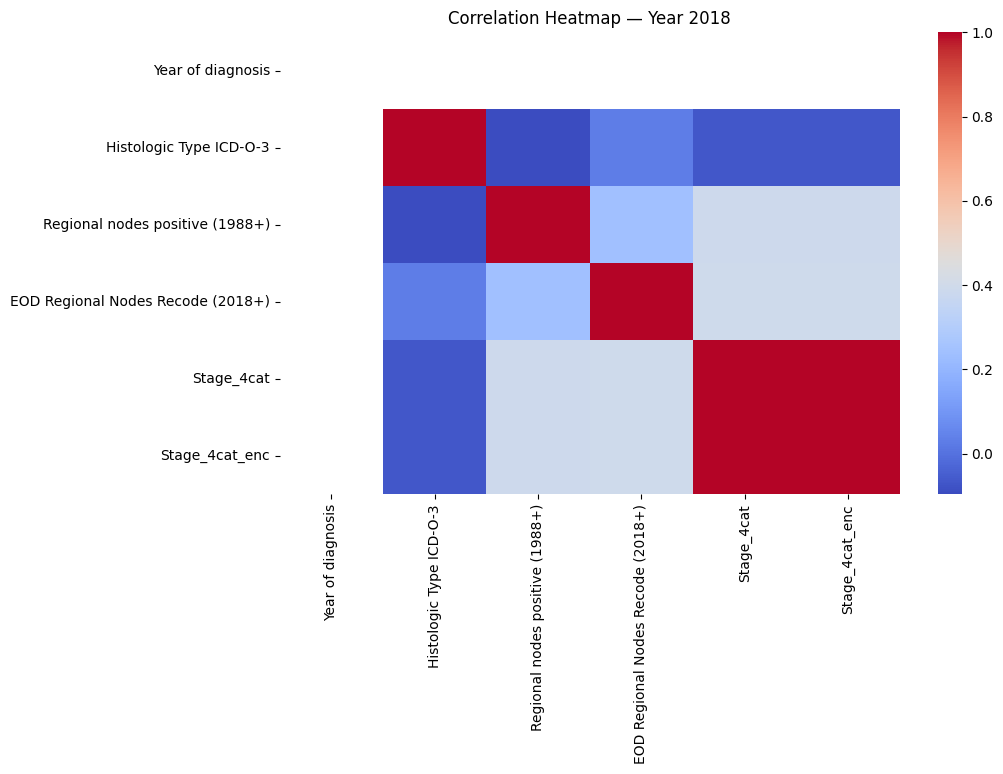


🔹 Correlation matrix for 2019:


,Year of diagnosis,Histologic Type ICD-O-3,Regional nodes positive (1988+),EOD Regional Nodes Recode (2018+),Stage_4cat,Stage_4cat_enc
Year of diagnosis,NaN,NaN,NaN,NaN,NaN,NaN
Histologic Type ICD-O-3,NaN,1.000000,-0.116817,0.044478,-0.033887,-0.033887
Regional nodes positive (1988+),NaN,-0.116817,1.000000,0.230716,0.393782,0.393782
EOD Regional Nodes Recode (2018+),NaN,0.044478,0.230716,1.000000,0.393353,0.393353
Stage_4cat,NaN,-0.033887,0.393782,0.393353,1.000000,1.000000
Stage_4cat_enc,NaN,-0.033887,0.393782,0.393353,1.000000,1.000000


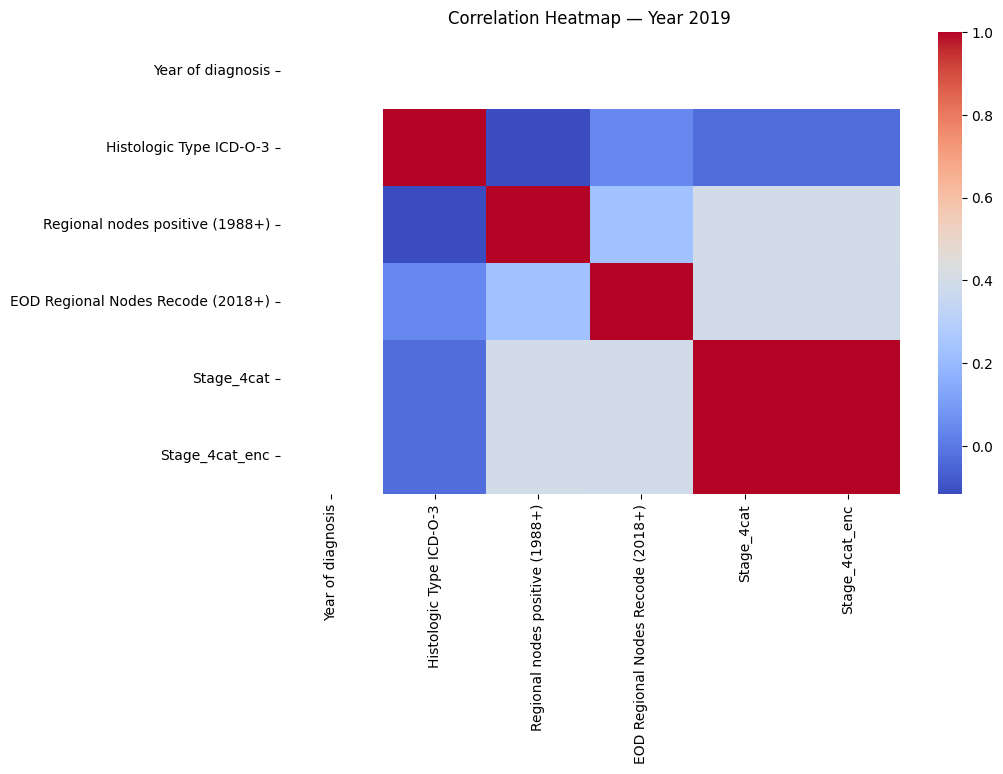


🔹 Correlation matrix for 2020:


,Year of diagnosis,Histologic Type ICD-O-3,Regional nodes positive (1988+),EOD Regional Nodes Recode (2018+),Stage_4cat,Stage_4cat_enc
Year of diagnosis,NaN,NaN,NaN,NaN,NaN,NaN
Histologic Type ICD-O-3,NaN,1.000000,-0.135841,0.017815,-0.071616,-0.071616
Regional nodes positive (1988+),NaN,-0.135841,1.000000,0.239335,0.386917,0.386917
EOD Regional Nodes Recode (2018+),NaN,0.017815,0.239335,1.000000,0.408428,0.408428
Stage_4cat,NaN,-0.071616,0.386917,0.408428,1.000000,1.000000
Stage_4cat_enc,NaN,-0.071616,0.386917,0.408428,1.000000,1.000000


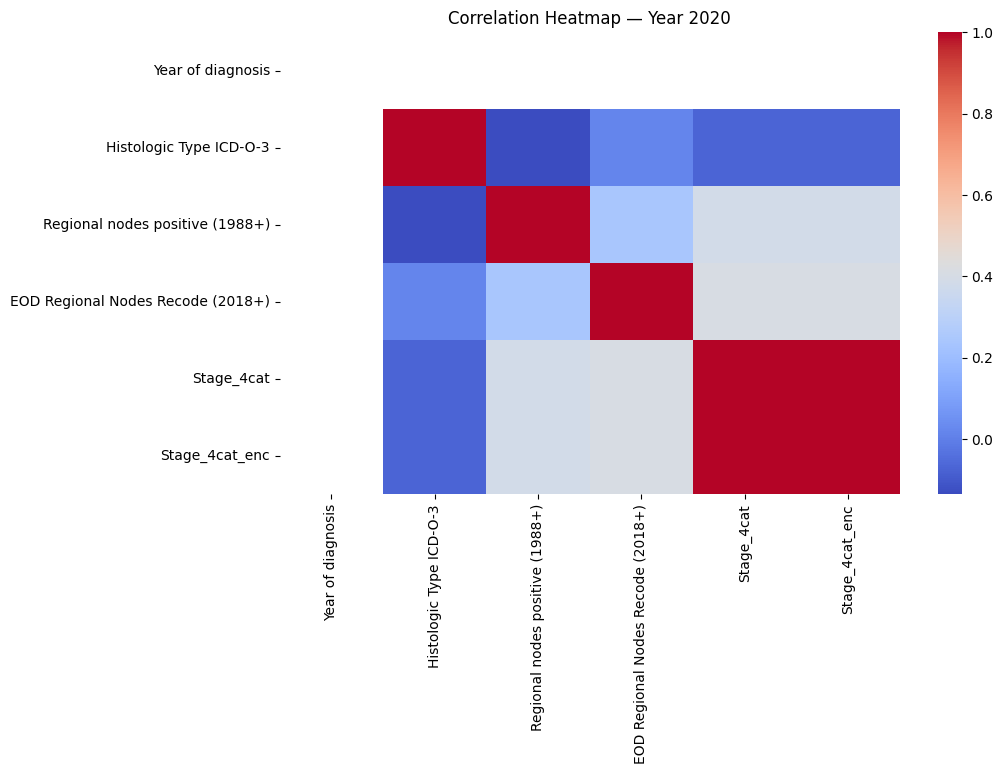


🔹 Correlation matrix for 2021:


,Year of diagnosis,Histologic Type ICD-O-3,Regional nodes positive (1988+),EOD Regional Nodes Recode (2018+),Stage_4cat,Stage_4cat_enc
Year of diagnosis,NaN,NaN,NaN,NaN,NaN,NaN
Histologic Type ICD-O-3,NaN,1.000000,-0.129133,0.003695,-0.071874,-0.071874
Regional nodes positive (1988+),NaN,-0.129133,1.000000,0.288702,0.440778,0.440778
EOD Regional Nodes Recode (2018+),NaN,0.003695,0.288702,1.000000,0.638386,0.638386
Stage_4cat,NaN,-0.071874,0.440778,0.638386,1.000000,1.000000
Stage_4cat_enc,NaN,-0.071874,0.440778,0.638386,1.000000,1.000000


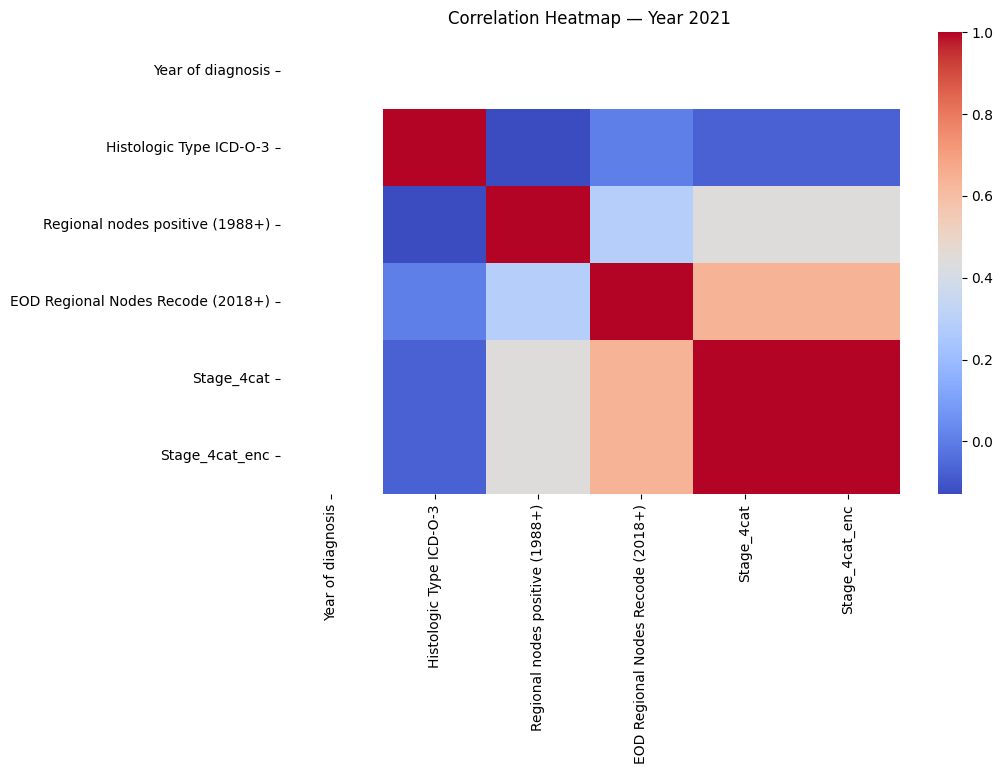


🔹 Correlation matrix for 2022:


,Year of diagnosis,Histologic Type ICD-O-3,Regional nodes positive (1988+),EOD Regional Nodes Recode (2018+),Stage_4cat,Stage_4cat_enc
Year of diagnosis,NaN,NaN,NaN,NaN,NaN,NaN
Histologic Type ICD-O-3,NaN,1.000000,-0.183457,-0.002421,-0.154650,-0.154650
Regional nodes positive (1988+),NaN,-0.183457,1.000000,0.283046,0.442220,0.442220
EOD Regional Nodes Recode (2018+),NaN,-0.002421,0.283046,1.000000,0.606335,0.606335
Stage_4cat,NaN,-0.154650,0.442220,0.606335,1.000000,1.000000
Stage_4cat_enc,NaN,-0.154650,0.442220,0.606335,1.000000,1.000000


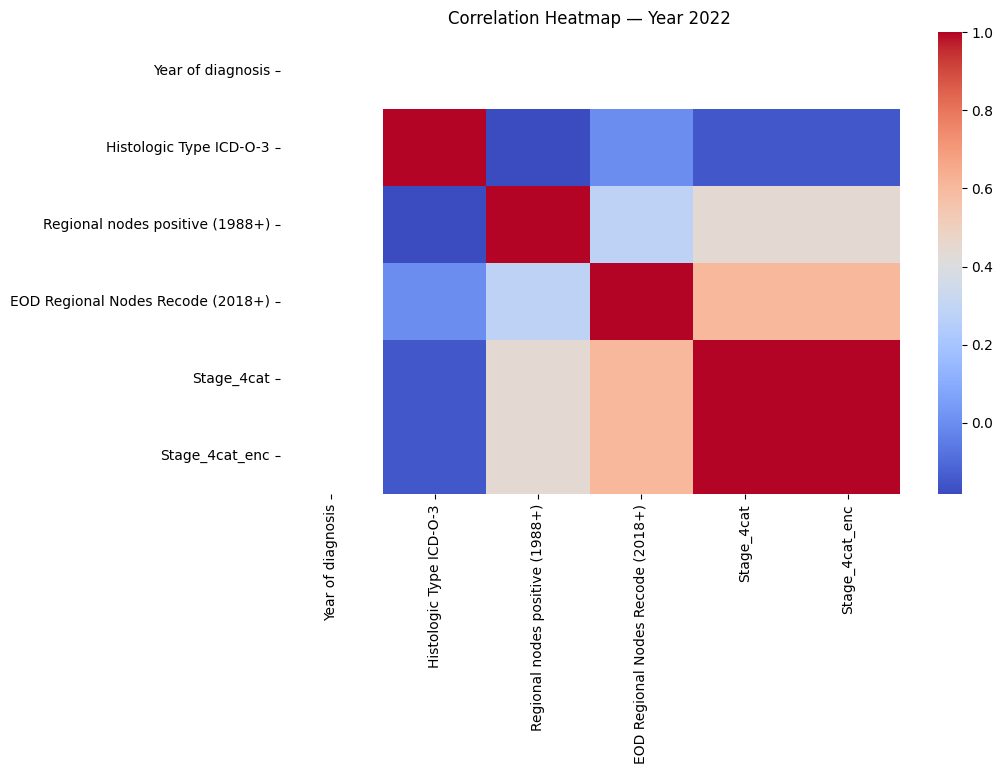

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

years = [2018, 2019, 2020, 2021, 2022]

for yr in years:
    df_year = df[df["Year of diagnosis"] == yr]
    numeric_df = df_year.select_dtypes(include=["number"])

    if numeric_df.shape[1] < 2:
        print(f"\nYear {yr} — Not enough numeric columns for correlation matrix.")
        continue

    corr = numeric_df.corr()

    print(f"\n🔹 Correlation matrix for {yr}:")
    display(corr)

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.title(f"Correlation Heatmap — Year {yr}")
    plt.show()


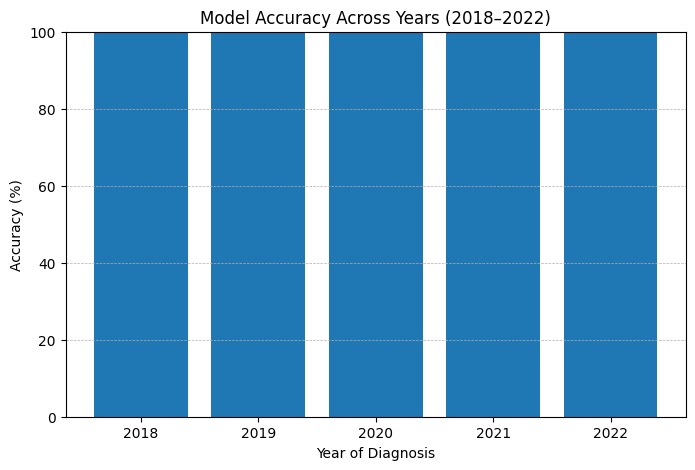

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# list of years we want to analyze
years = [2018, 2019, 2020, 2021, 2022]

accuracy_results = []

for yr in years:
    df_year = df[df["Year of diagnosis"] == yr]

    if df_year.empty:
        continue

    X_year = df_year[X.columns]
    y_year = df_year["Stage_4cat_enc"]

    y_pred_year = pipe.predict(X_year)
    acc = accuracy_score(y_year, y_pred_year) * 100
    accuracy_results.append((yr, acc))

# separate values for plotting
year_labels = [item[0] for item in accuracy_results]
accuracy_scores = [item[1] for item in accuracy_results]

# plot
plt.figure(figsize=(8, 5))
plt.bar(year_labels, accuracy_scores)
plt.title("Model Accuracy Across Years (2018–2022)")
plt.xlabel("Year of Diagnosis")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)  # adjust height scale if needed
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


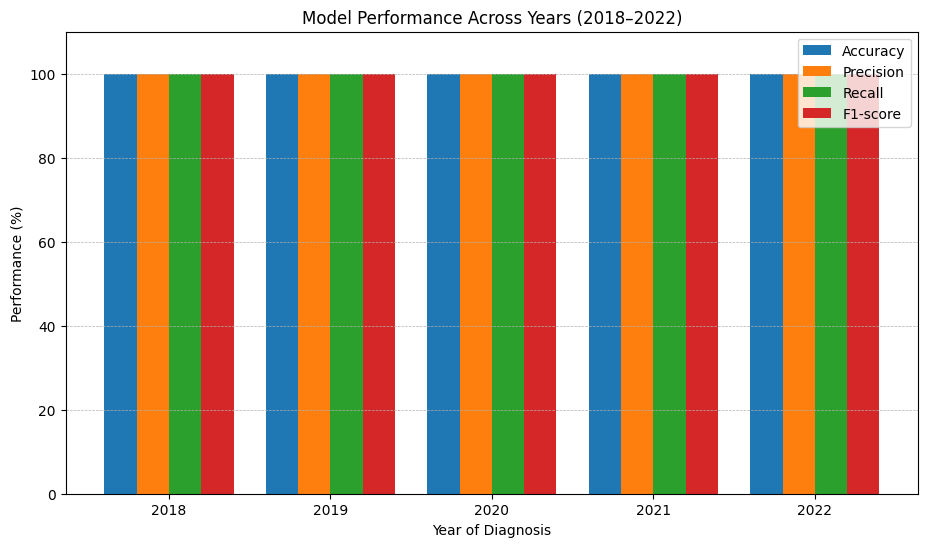

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

years = [2018, 2019, 2020, 2021, 2022]

results = { "Year": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": [] }

for yr in years:
    df_year = df[df["Year of diagnosis"] == yr]
    if df_year.empty:
        continue

    X_year = df_year[X.columns]
    y_year = df_year["Stage_4cat_enc"]

    y_pred_year = pipe.predict(X_year)

    acc  = accuracy_score(y_year, y_pred_year) * 100
    prec = precision_score(y_year, y_pred_year, average='weighted') * 100
    rec  = recall_score(y_year, y_pred_year, average='weighted') * 100
    f1   = f1_score(y_year, y_pred_year, average='weighted') * 100

    results["Year"].append(yr)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1"].append(f1)

# ---- BAR GRAPH ----
labels = results["Year"]
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(11, 6))
plt.bar(x - 1.5*width, results["Accuracy"], width, label="Accuracy")
plt.bar(x - 0.5*width, results["Precision"], width, label="Precision")
plt.bar(x + 0.5*width, results["Recall"], width, label="Recall")
plt.bar(x + 1.5*width, results["F1"], width, label="F1-score")

plt.xticks(x, labels)
plt.xlabel("Year of Diagnosis")
plt.ylabel("Performance (%)")
plt.title("Model Performance Across Years (2018–2022)")
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = pipe.predict(X_test)

acc_lib  = accuracy_score(y_test, y_pred_test) * 100
prec_lib = precision_score(y_test, y_pred_test, average='weighted') * 100
rec_lib  = recall_score(y_test, y_pred_test, average='weighted') * 100
f1_lib   = f1_score(y_test, y_pred_test, average='weighted') * 100

# Manual confusion matrix calculation
cm = confusion_matrix(y_test, y_pred_test)
TP_total = cm.trace()
Total = cm.sum()
acc_manual = (TP_total / Total) * 100

print("\n--- ACCURACY CHECK ---")
print("Library:", acc_lib, " Manual:", acc_manual, " →", "PASS" if abs(acc_lib-acc_manual) < 1e-6 else "FAIL")

# Per class manual precision / recall / F1
import numpy as np
precisions = []
recalls = []
f1s = []
supports = np.sum(cm, axis=1)

for i in range(len(cm)):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

weighted_precision_manual = np.sum(np.array(precisions) * supports) / Total * 100
weighted_recall_manual    = np.sum(np.array(recalls) * supports) / Total * 100
weighted_f1_manual        = np.sum(np.array(f1s) * supports) / Total * 100

print("\n--- PRECISION CHECK ---")
print("Library:", prec_lib, " Manual:", weighted_precision_manual,
      " →", "PASS" if abs(prec_lib-weighted_precision_manual) < 1e-6 else "FAIL")

print("\n--- RECALL CHECK ---")
print("Library:", rec_lib, " Manual:", weighted_recall_manual,
      " →", "PASS" if abs(rec_lib-weighted_recall_manual) < 1e-6 else "FAIL")

print("\n--- F1 CHECK ---")
print("Library:", f1_lib, " Manual:", weighted_f1_manual,
      " →", "PASS" if abs(f1_lib-weighted_f1_manual) < 1e-6 else "FAIL")



--- ACCURACY CHECK ---
Library: 100.0  Manual: 100.0  → PASS

--- PRECISION CHECK ---
Library: 100.0  Manual: 100.0  → PASS

--- RECALL CHECK ---
Library: 100.0  Manual: 100.0  → PASS

--- F1 CHECK ---
Library: 100.0  Manual: 100.0  → PASS


In [33]:
# After training pipe
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_pred_train) * 100
test_acc = accuracy_score(y_test, y_pred_test) * 100

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 100.0
Test Accuracy: 100.0


In [34]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print("CV scores:", cv_scores)
print("Mean:", cv_scores.mean()*100)


CV scores: [1. 1. 1. 1. 1.]
Mean: 100.0


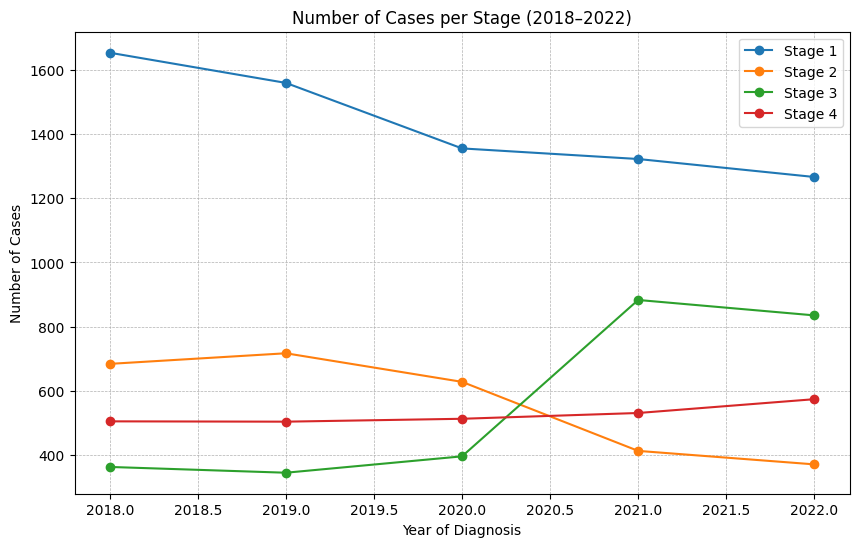

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# convert encoded stage to actual stage number for readability
df["Stage"] = df["Stage_4cat_enc"] + 1   # 0→1, 1→2, 2→3, 3→4

stage_counts = df.groupby(["Year of diagnosis", "Stage"]).size().reset_index(name="count")

plt.figure(figsize=(10,6))
for stage in sorted(stage_counts["Stage"].unique()):
    subset = stage_counts[stage_counts["Stage"] == stage]
    plt.plot(subset["Year of diagnosis"], subset["count"], marker='o', label=f"Stage {stage}")

plt.xlabel("Year of Diagnosis")
plt.ylabel("Number of Cases")
plt.title("Number of Cases per Stage (2018–2022)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


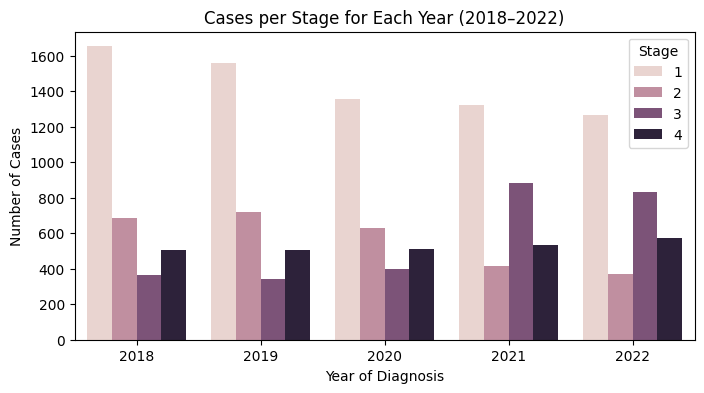

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Year of diagnosis", hue="Stage")
plt.title("Cases per Stage for Each Year (2018–2022)")
plt.xlabel("Year of Diagnosis")
plt.ylabel("Number of Cases")
plt.legend(title="Stage")
plt.show()


In [51]:
for lr in [0.3, 0.1, 0.05, 0.01, 0.005]:
    for est in [100, 300, 600, 1000]:
        model = XGBClassifier(
            n_estimators=est,
            learning_rate=lr,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42
        )
        pipe2 = Pipeline([("preprocess", preprocess), ("model", model)])
        pipe2.fit(X_train, y_train)
        y_pred = pipe2.predict(X_test)
        print(f"lr={lr}, est={est} → accuracy = {accuracy_score(y_test, y_pred)*100:.2f}%")


lr=0.3, est=100 → accuracy = 100.00%
lr=0.3, est=300 → accuracy = 100.00%
lr=0.3, est=600 → accuracy = 100.00%
lr=0.3, est=1000 → accuracy = 100.00%
lr=0.1, est=100 → accuracy = 100.00%
lr=0.1, est=300 → accuracy = 100.00%
lr=0.1, est=600 → accuracy = 100.00%
lr=0.1, est=1000 → accuracy = 100.00%
lr=0.05, est=100 → accuracy = 100.00%
lr=0.05, est=300 → accuracy = 100.00%
lr=0.05, est=600 → accuracy = 100.00%
lr=0.05, est=1000 → accuracy = 100.00%
lr=0.01, est=100 → accuracy = 100.00%
lr=0.01, est=300 → accuracy = 100.00%
lr=0.01, est=600 → accuracy = 100.00%
lr=0.01, est=1000 → accuracy = 100.00%
lr=0.005, est=100 → accuracy = 100.00%
lr=0.005, est=300 → accuracy = 100.00%
lr=0.005, est=600 → accuracy = 100.00%
lr=0.005, est=1000 → accuracy = 100.00%
